## Feature Selection Comparison:
1. Load UCI Credit dataset.
2. Create noisy data with make classification.
3. Try different Feature selection algorithms.
4. Compare results.
5. Conclusion

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import shap
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from stability_selection import StabilitySelection, plot_stability_path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import cross_val_score,cross_validate
from xgboost import XGBClassifier

### 1. Read UCI Credit Card and add noise.

In [8]:
data = pd.read_csv('data/train_fin_cols.csv')

y_org = data['loan_default']
X_org = data.drop(['loan_default'],axis=1)

print("Loaded train data with shape {}".format(X_org.shape))

categorical_columns_to_drop = ['uniqueid','branch_id','supplier_id','manufacturer_id','current_pincode_id',
                               'state_id','employee_code_id','perform_cns_score_description','employment_type','state_hrg','emp_hrg',
                              'branch_hrg','pincode_hrg','supplier_hrg','manf_hrg']
categorical_columns = ['employment_type','perform_cns_score_description']

X_lnt = X_org.drop(categorical_columns_to_drop,axis=1)
X_lnt.head()

Loaded train data with shape (233154, 58)


,disbursed_amount,asset_cost,ltv,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,...,score_hrg,scored,amt_rejected,loan_to_pbal,sec_loan_to_pbal,pri_avg_installments,pri_avg_active_installments,sec_avg_installments,sec_avg_active_installments,tenure_primary
0,50578.0,58400.0,89.55,1,1,0,0,0,0,0,...,0,0,0.133938,50578.00000,50578.0,0.0,0.0,0.0,0.0,0.000000
1,47145.0,65550.0,73.23,1,1,0,0,0,0,598,...,1,1,0.280778,1.70809,47145.0,50200.0,50200.0,0.0,0.0,2.100067
2,53278.0,61360.0,89.63,1,1,0,0,0,0,0,...,0,0,0.131714,53278.00000,53278.0,0.0,0.0,0.0,0.0,0.000000
3,57513.0,66113.0,88.48,1,1,0,0,0,0,305,...,1,1,0.130080,57513.00000,57513.0,0.0,0.0,0.0,0.0,0.000000
4,52378.0,60300.0,88.39,1,1,0,0,0,0,0,...,0,0,0.131376,52378.00000,52378.0,0.0,0.0,0.0,0.0,0.000000


In [9]:
# Drop co-related features :

# Create correlation matrix
corr_matrix = X_lnt.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

X_lnt = X_lnt.drop(to_drop,axis=1)

print(f'Shape of df after initial cleaning :{X_lnt.shape}')
X_train, X_test, y_train, y_test = train_test_split(X_lnt, y_org,
                                                    test_size=0.3,random_state=345)


Shape of df after initial cleaning :(233154, 36)


### 2.Stability Selection:

Fitting estimator for lambda = 4.00000 (1 / 6) on 100 bootstrap samples


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   16.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting estimator for lambda = 5.00000 (2 / 6) on 100 bootstrap samples


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   18.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting estimator for lambda = 6.00000 (3 / 6) on 100 bootstrap samples


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   19.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting estimator for lambda = 7.00000 (4 / 6) on 100 bootstrap samples


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   21.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting estimator for lambda = 8.00000 (5 / 6) on 100 bootstrap samples


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   25.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting estimator for lambda = 9.00000 (6 / 6) on 100 bootstrap samples


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   29.8s finished


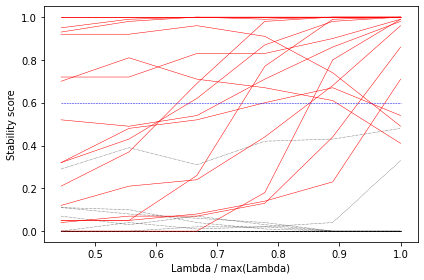

In [10]:
base_estimator = Pipeline([
    ('model', RandomForestClassifier(max_depth=4,n_estimators=10,n_jobs=4))])

selector = StabilitySelection(base_estimator=base_estimator,
                              lambda_name='model__max_depth',
                              n_bootstrap_iterations=100,
                              n_jobs=4,
                              lambda_grid=np.arange(4,10,step=1),
                              verbose=1)
selector.fit(X_train,y_train)

fig, ax = plot_stability_path(selector)
fig.show()

In [11]:
# Print the names of the most important features
selected_variables = selector.get_support(indices=True)
selected_scores = selector.stability_scores_.max(axis=1)
ss_flist = []
for feature_list_index in selector.get_support(indices=True):
    print(f'Variable Name : {X_lnt.columns[feature_list_index]} \t Stability Score :{selected_scores[feature_list_index]}')
    ss_flist.append(X_lnt.columns[feature_list_index])

ss_flist = sorted(ss_flist)

n_feats = len(ss_flist)
print(f'No.of features selected {n_feats} \n')

Variable Name : disbursed_amount 	 Stability Score :1.0
Variable Name : asset_cost 	 Stability Score :1.0
Variable Name : ltv 	 Stability Score :1.0
Variable Name : perform_cns_score 	 Stability Score :1.0
Variable Name : pri_overdue_accts 	 Stability Score :0.81
Variable Name : pri_current_balance 	 Stability Score :0.99
Variable Name : no_of_inquiries 	 Stability Score :0.67
Variable Name : age_when_disbursal 	 Stability Score :0.99
Variable Name : avg_acct_age_m 	 Stability Score :0.71
Variable Name : credit_hist_len_m 	 Stability Score :1.0
Variable Name : ltv_delta 	 Stability Score :1.0
Variable Name : score_hrg 	 Stability Score :0.96
Variable Name : loan_to_pbal 	 Stability Score :1.0
Variable Name : sec_loan_to_pbal 	 Stability Score :1.0
Variable Name : pri_avg_installments 	 Stability Score :0.86
Variable Name : pri_avg_active_installments 	 Stability Score :0.98
Variable Name : tenure_primary 	 Stability Score :0.96
No.of features selected 17 



### 3.SHAP Feature Importances

In [12]:
# Build the model with the random forest regression algorithm:
model = RandomForestClassifier(max_depth=4, random_state=456, n_estimators=20)
model.fit(X_train,y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train,y_train,check_additivity=False)

shap_vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_lnt.columns, sum(shap_vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
shap_flist = list(feature_importance.col_name[0:n_feats])

shap_flist = sorted(shap_flist)
print(shap_flist)

['ltv', 'perform_cns_score', 'score_hrg', 'sec_loan_to_pbal', 'loan_to_pbal', 'disbursed_amount', 'tenure_primary', 'pri_current_balance', 'pri_overdue_accts', 'no_of_inquiries', 'aadhar_flag', 'pri_no_of_accts', 'credit_hist_len_m', 'pri_avg_active_installments', 'age_when_disbursal', 'avg_acct_age_m', 'voterid_flag']


### 4.MLXtend SFS

In [13]:
sfs1 = SFS(model, 
           k_features=(n_feats-5,n_feats), 
           forward=True, 
           floating=True, 
           verbose=1,
           scoring='roc_auc',
           n_jobs=6,
           cv=3)

sfs1 = sfs1.fit(X_train, y_train)
sfs1_flist=list(sfs1.k_feature_names_)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  36 out of  36 | elapsed:   14.2s finished
Features: 1/17[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:   20.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.0s finished
Features: 2/17[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  34 out of  34 | elapsed:   19.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    3.1s finished
Features: 3/17[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  33 out of  33 | elapsed:   25.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_j

### 5.Combine selected features.

In [14]:
sfs1_flist= sorted(sfs1_flist)
print(sfs1_flist)

total_fs_list=list(set(sfs1_flist+ss_flist+shap_flist))

fs_method_list = [("SS",ss_flist),
                  ("SFS",sfs1_flist),
                  ("SHAP",shap_flist),
                  ("FSP",total_fs_list),
                  ("All Columns",list(X_lnt.columns))]

result_df = pd.DataFrame()

# xgb_params={'n_estimators': 284, 'max_depth': 18, 
#             'min_child_weight': 6, 'scale_pos_weight': 66, 
#             'subsample': 0.8, 'colsample_bytree': 0.8}

for feature_list in fs_method_list:
    
    print(f'Features selected with {feature_list[0]} : {feature_list[1]} \n')
    X_fs = X_lnt[feature_list[1]]
    clf = XGBClassifier()
    scores = cross_validate(clf,X_fs,y_org,cv=5,scoring='roc_auc',return_train_score=True)
    
    result_df[f'{feature_list[0]}_mean_train_score']=scores['train_score']
    result_df[f'{feature_list[0]}_mean_test_score']=scores['test_score']
    result_df[f'{feature_list[0]}_mean_overfit']=(scores['train_score']-scores['test_score'])


['asset_cost', 'ltv', 'aadhar_flag', 'voterid_flag', 'passport_flag', 'perform_cns_score', 'pri_no_of_accts', 'pri_active_accts', 'pri_overdue_accts', 'sec_instal_amt', 'delinquent_accts_in_last_six_months', 'no_of_inquiries', 'age_when_disbursal', 'credit_hist_len_m', 'loan_to_pbal', 'tenure_primary']
Features selected with SS : ['disbursed_amount', 'asset_cost', 'ltv', 'perform_cns_score', 'pri_overdue_accts', 'pri_current_balance', 'no_of_inquiries', 'age_when_disbursal', 'avg_acct_age_m', 'credit_hist_len_m', 'ltv_delta', 'score_hrg', 'loan_to_pbal', 'sec_loan_to_pbal', 'pri_avg_installments', 'pri_avg_active_installments', 'tenure_primary'] 

Features selected with SFS : ['asset_cost', 'ltv', 'aadhar_flag', 'voterid_flag', 'passport_flag', 'perform_cns_score', 'pri_no_of_accts', 'pri_active_accts', 'pri_overdue_accts', 'sec_instal_amt', 'delinquent_accts_in_last_six_months', 'no_of_inquiries', 'age_when_disbursal', 'credit_hist_len_m', 'loan_to_pbal', 'tenure_primary'] 

Features 

### 6.Results

In [15]:
result_df

,SS_mean_train_score,SS_mean_test_score,SS_mean_overfit,SFS_mean_train_score,SFS_mean_test_score,SFS_mean_overfit,SHAP_mean_train_score,SHAP_mean_test_score,SHAP_mean_overfit,FSP_mean_train_score,FSP_mean_test_score,FSP_mean_overfit,All Columns_mean_train_score,All Columns_mean_test_score,All Columns_mean_overfit
0,0.719179,0.623817,0.095361,0.712449,0.628729,0.083721,0.710887,0.627446,0.083441,0.721430,0.628628,0.092803,0.720218,0.628721,0.091497
1,0.718138,0.628391,0.089747,0.710358,0.635192,0.075166,0.711108,0.634240,0.076869,0.720550,0.636574,0.083976,0.723555,0.638253,0.085302
2,0.718523,0.622955,0.095567,0.711736,0.630858,0.080878,0.711509,0.632185,0.079324,0.718471,0.629362,0.089109,0.723579,0.628632,0.094947
3,0.719191,0.626404,0.092787,0.712140,0.631706,0.080435,0.710176,0.631165,0.079012,0.725144,0.631711,0.093432,0.723293,0.629384,0.093910
4,0.720211,0.617281,0.102930,0.710207,0.622772,0.087435,0.711527,0.620355,0.091172,0.722669,0.623104,0.099565,0.723906,0.622555,0.101351


In [16]:
result_df.apply(lambda x :np.mean(x),axis=0)

SS_mean_train_score             0.719048
SS_mean_test_score              0.623770
SS_mean_overfit                 0.095278
SFS_mean_train_score            0.711378
SFS_mean_test_score             0.629851
SFS_mean_overfit                0.081527
SHAP_mean_train_score           0.711042
SHAP_mean_test_score            0.629078
SHAP_mean_overfit               0.081963
FSP_mean_train_score            0.721653
FSP_mean_test_score             0.629876
FSP_mean_overfit                0.091777
All Columns_mean_train_score    0.722910
All Columns_mean_test_score     0.629509
All Columns_mean_overfit        0.093401
dtype: float64

### Appendix
Optimisation using Optuna.

In [17]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import optuna
import functools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,accuracy_score,f1_score,roc_auc_score

In [27]:
def opt(X_train, y_train, X_test, y_test, trial):
    #param_list
    n_estimators = trial.suggest_int('n_estimators',0,500)
    max_depth = trial.suggest_int('max_depth', 1,10)
    min_child_weight = trial.suggest_int('min_child_weight', 1,10)
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.01, 0.1,0.01)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1,30)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)

    xgboost_tuna = xgb.XGBClassifier(
        random_state=946, 
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        learning_rate = learning_rate,
        scale_pos_weight = scale_pos_weight,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
    )
    xgboost_tuna.fit(X_train, y_train)
    tuna_pred_test = xgboost_tuna.predict_proba(X_test)[:,1]
    
    return (1.0 - (roc_auc_score(y_test,tuna_pred_test)))

def get_opt_parameters(X,y):
    """
    Takes X,y and returns best parameters.
    
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.7,random_state=345)
    study = optuna.create_study()
    study.optimize(functools.partial(opt,X_train, y_train, X_test, y_test),n_trials=10)
    return study.best_params
    

In [28]:
fs_method_list = [("SS",ss_flist),
                  ("SFS",sfs1_flist),
                  ("SHAP",shap_flist),
                  ("FSP",total_fs_list)]

result_df = pd.DataFrame()

for feature_list in fs_method_list:
    
    print(f'Features selected with {feature_list[0]} : {feature_list[1]} \n')
    
    X_fs = X_lnt[feature_list[1]]
    optimised_param = get_opt_parameters(X_fs,y_org)
    
    clf = XGBClassifier(**optimised_param)
    
    scores = cross_validate(clf,X_fs,y_org,cv=3,scoring='roc_auc',return_train_score=True)
    
    result_df[f'{feature_list[0]}_mean_train_score']=scores['train_score']
    result_df[f'{feature_list[0]}_mean_test_score']=scores['test_score']
    result_df[f'{feature_list[0]}_mean_overfit']=(scores['train_score']-scores['test_score'])

Features selected with SS : ['disbursed_amount', 'asset_cost', 'ltv', 'perform_cns_score', 'pri_overdue_accts', 'pri_current_balance', 'no_of_inquiries', 'age_when_disbursal', 'avg_acct_age_m', 'credit_hist_len_m', 'ltv_delta', 'score_hrg', 'loan_to_pbal', 'sec_loan_to_pbal', 'pri_avg_installments', 'pri_avg_active_installments', 'tenure_primary'] 



[I 2020-04-14 21:33:20,830] Finished trial#0 with value: 0.38573908405990043 with parameters: {'n_estimators': 15, 'max_depth': 8, 'min_child_weight': 10, 'learning_rate': 0.03, 'scale_pos_weight': 20, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#0 with value: 0.38573908405990043.
[I 2020-04-14 21:33:29,445] Finished trial#1 with value: 0.37764823660497804 with parameters: {'n_estimators': 400, 'max_depth': 1, 'min_child_weight': 3, 'learning_rate': 0.09, 'scale_pos_weight': 24, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#1 with value: 0.37764823660497804.
[I 2020-04-14 21:33:54,496] Finished trial#2 with value: 0.3946403555155056 with parameters: {'n_estimators': 272, 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.09, 'scale_pos_weight': 15, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#1 with value: 0.37764823660497804.
[I 2020-04-14 21:34:16,887] Finished trial#3 with value: 0.3865571792035889 with parameters: {'n_estimators': 168, '

Features selected with SFS : ['asset_cost', 'ltv', 'aadhar_flag', 'voterid_flag', 'passport_flag', 'perform_cns_score', 'pri_no_of_accts', 'pri_active_accts', 'pri_overdue_accts', 'sec_instal_amt', 'delinquent_accts_in_last_six_months', 'no_of_inquiries', 'age_when_disbursal', 'credit_hist_len_m', 'loan_to_pbal', 'tenure_primary'] 



[I 2020-04-14 21:40:23,230] Finished trial#0 with value: 0.36809351292948955 with parameters: {'n_estimators': 477, 'max_depth': 5, 'min_child_weight': 9, 'learning_rate': 0.02, 'scale_pos_weight': 19, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial#0 with value: 0.36809351292948955.
[I 2020-04-14 21:40:28,214] Finished trial#1 with value: 0.37556084112107346 with parameters: {'n_estimators': 99, 'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.03, 'scale_pos_weight': 29, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#0 with value: 0.36809351292948955.
[I 2020-04-14 21:41:14,616] Finished trial#2 with value: 0.4089854393666701 with parameters: {'n_estimators': 343, 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.08, 'scale_pos_weight': 30, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial#0 with value: 0.36809351292948955.
[I 2020-04-14 21:41:26,859] Finished trial#3 with value: 0.36675249748414107 with parameters: {'n_estimators': 191, 

Features selected with SHAP : ['ltv', 'perform_cns_score', 'score_hrg', 'sec_loan_to_pbal', 'loan_to_pbal', 'disbursed_amount', 'tenure_primary', 'pri_current_balance', 'pri_overdue_accts', 'no_of_inquiries', 'aadhar_flag', 'pri_no_of_accts', 'credit_hist_len_m', 'pri_avg_active_installments', 'age_when_disbursal', 'avg_acct_age_m', 'voterid_flag'] 



[I 2020-04-14 21:43:37,668] Finished trial#0 with value: 0.38065640637493237 with parameters: {'n_estimators': 94, 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.01, 'scale_pos_weight': 22, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#0 with value: 0.38065640637493237.
[I 2020-04-14 21:44:06,560] Finished trial#1 with value: 0.3824572940862516 with parameters: {'n_estimators': 272, 'max_depth': 8, 'min_child_weight': 8, 'learning_rate': 0.09, 'scale_pos_weight': 2, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#0 with value: 0.38065640637493237.
[I 2020-04-14 21:44:16,167] Finished trial#2 with value: 0.3828189981187604 with parameters: {'n_estimators': 128, 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.09999999999999999, 'scale_pos_weight': 13, 'subsample': 0.5, 'colsample_bytree': 0.6}. Best is trial#0 with value: 0.38065640637493237.
[I 2020-04-14 21:44:23,504] Finished trial#3 with value: 0.3814235283033305 with parameters: {'n_estimat

Features selected with FSP : ['sec_instal_amt', 'sec_loan_to_pbal', 'avg_acct_age_m', 'age_when_disbursal', 'pri_current_balance', 'pri_no_of_accts', 'perform_cns_score', 'pri_overdue_accts', 'ltv', 'asset_cost', 'aadhar_flag', 'loan_to_pbal', 'tenure_primary', 'ltv_delta', 'delinquent_accts_in_last_six_months', 'credit_hist_len_m', 'pri_avg_active_installments', 'pri_avg_installments', 'no_of_inquiries', 'disbursed_amount', 'score_hrg', 'pri_active_accts', 'passport_flag', 'voterid_flag'] 



[I 2020-04-14 21:48:33,821] Finished trial#0 with value: 0.37082094143931865 with parameters: {'n_estimators': 435, 'max_depth': 5, 'min_child_weight': 3, 'learning_rate': 0.05, 'scale_pos_weight': 15, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#0 with value: 0.37082094143931865.
[I 2020-04-14 21:48:53,329] Finished trial#1 with value: 0.3667189338014354 with parameters: {'n_estimators': 293, 'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.08, 'scale_pos_weight': 3, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#1 with value: 0.3667189338014354.
[I 2020-04-14 21:50:02,258] Finished trial#2 with value: 0.40165146770385474 with parameters: {'n_estimators': 430, 'max_depth': 10, 'min_child_weight': 6, 'learning_rate': 0.08, 'scale_pos_weight': 24, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#1 with value: 0.3667189338014354.
[I 2020-04-14 21:50:35,180] Finished trial#3 with value: 0.37339498478587885 with parameters: {'n_estimators': 263, 'm

In [29]:
result_df.apply(lambda x :np.mean(x),axis=0)

SS_mean_train_score      0.657403
SS_mean_test_score       0.628603
SS_mean_overfit          0.028800
SFS_mean_train_score     0.669467
SFS_mean_test_score      0.635985
SFS_mean_overfit         0.033482
SHAP_mean_train_score    0.709751
SHAP_mean_test_score     0.629010
SHAP_mean_overfit        0.080741
FSP_mean_train_score     0.671306
FSP_mean_test_score      0.636073
FSP_mean_overfit         0.035232
dtype: float64